In [44]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn.functional as F

In [3]:
# Load the training data
data = MNIST(root="data", download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
len(data)

60000

In [5]:
test = MNIST(root="data", train=False, download=True)
len(test)

10000

In [6]:
data[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

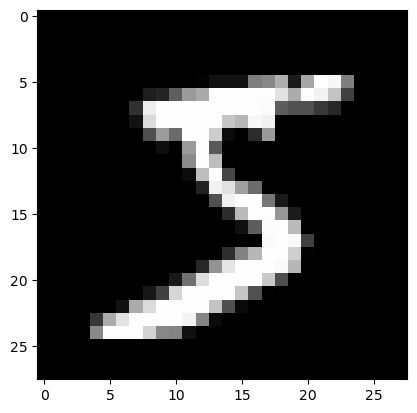

5


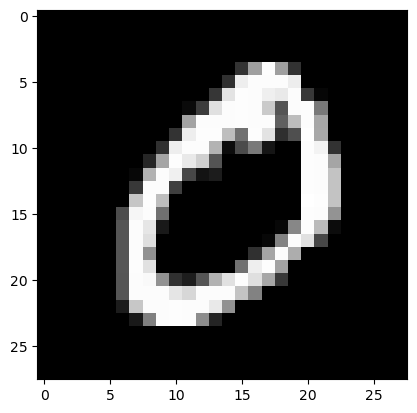

0


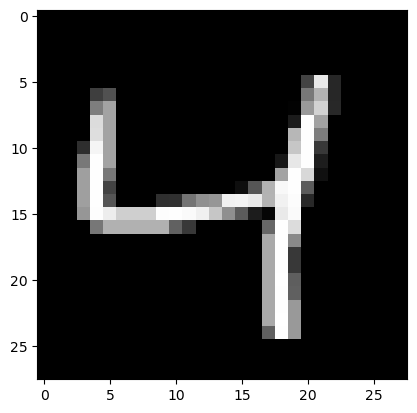

4


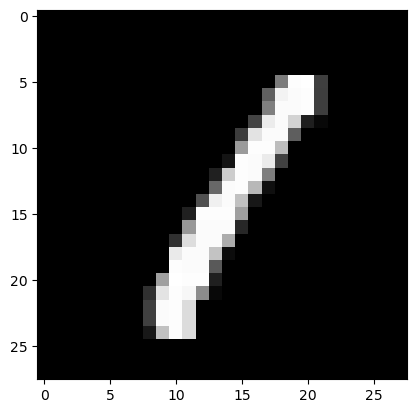

1


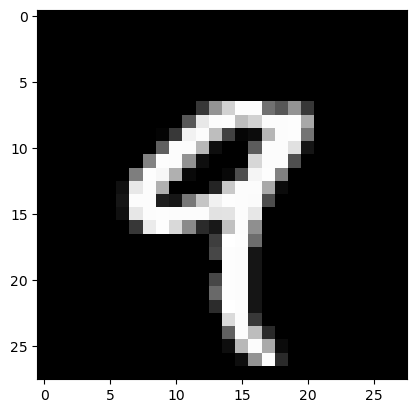

9


In [9]:
for i in range(5):
    img, label = data[i]
    plt.imshow(img, cmap="gray")
    plt.show()
    print(label)

In [10]:
import torchvision.transforms as transforms

In [11]:
dataset = MNIST(root="data", train=True, transform=transforms.ToTensor())

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [13]:
print(img_tensor[0, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


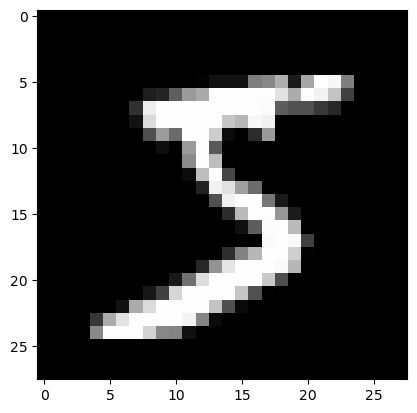

In [18]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0, :, :], cmap="gray")

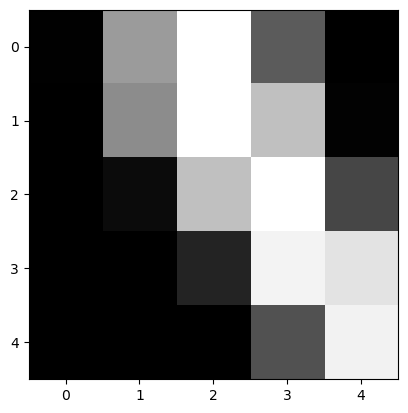

In [19]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0, 10:15, 10:15], cmap="gray")

In [20]:
from torch.utils.data import random_split

# training set is 50000
# validation set is 10000
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [21]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [22]:
import torch.nn as nn

input_size = 28 * 28
num_classes = 10

In [43]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss, "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["val_loss"], result["val_acc"]
            )
        )

In [45]:
model = MnistModel()
print(model.linear)
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

Linear(in_features=784, out_features=10, bias=True)
torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0127,  0.0136,  0.0307,  ..., -0.0323, -0.0055, -0.0340],
         [ 0.0112,  0.0062, -0.0288,  ...,  0.0189,  0.0343, -0.0322],
         [-0.0197, -0.0298,  0.0180,  ...,  0.0127,  0.0277,  0.0240],
         ...,
         [-0.0212, -0.0069,  0.0112,  ...,  0.0122, -0.0173,  0.0142],
         [-0.0049,  0.0124, -0.0172,  ..., -0.0147, -0.0157, -0.0019],
         [ 0.0093, -0.0193,  0.0308,  ..., -0.0274,  0.0015, -0.0293]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0289, -0.0148, -0.0148, -0.0065, -0.0132, -0.0030,  0.0187, -0.0215,
         -0.0160,  0.0006], requires_grad=True)]

In [46]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print("outputs.shape : ", outputs.shape)
print("Sample outputs :\n", outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0135, -0.1952,  0.0982,  0.0030,  0.0181,  0.0307, -0.2543,  0.0181,
         -0.3932, -0.3203],
        [ 0.1125, -0.0997,  0.0506, -0.2166, -0.0936,  0.0696,  0.1548, -0.1108,
         -0.0876, -0.3003]])


In [47]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1077, 0.0898, 0.1204, 0.1095, 0.1112, 0.1126, 0.0847, 0.1112, 0.0737,
         0.0793],
        [0.1168, 0.0944, 0.1098, 0.0840, 0.0950, 0.1119, 0.1218, 0.0934, 0.0956,
         0.0773]])
Sum:  1.0


In [48]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([2, 6, 2, 4, 0, 0, 0, 2, 3, 5, 7, 2, 2, 7, 8, 2, 6, 0, 7, 7, 3, 7, 5, 5,
        0, 2, 3, 5, 0, 2, 0, 2, 0, 5, 0, 2, 7, 2, 5, 7, 9, 2, 5, 1, 2, 2, 4, 5,
        8, 2, 8, 1, 5, 3, 2, 2, 1, 1, 2, 0, 5, 3, 0, 2, 2, 5, 2, 5, 0, 6, 5, 6,
        0, 8, 2, 0, 5, 0, 2, 5, 1, 0, 2, 9, 7, 2, 1, 5, 4, 5, 2, 0, 1, 1, 0, 2,
        7, 2, 0, 2, 2, 5, 7, 2, 0, 5, 2, 2, 5, 2, 2, 1, 5, 2, 1, 2, 4, 1, 2, 6,
        2, 0, 2, 2, 1, 1, 5, 0])
tensor([0.1204, 0.1218, 0.1303, 0.1116, 0.1121, 0.1258, 0.1198, 0.1205, 0.1199,
        0.1297, 0.1391, 0.1537, 0.1302, 0.1307, 0.1304, 0.1327, 0.1493, 0.1130,
        0.1259, 0.1238, 0.1251, 0.1312, 0.1213, 0.1194, 0.1180, 0.1423, 0.1255,
        0.1234, 0.1413, 0.1350, 0.1274, 0.1397, 0.1349, 0.1266, 0.1301, 0.1277,
        0.1140, 0.1524, 0.1225, 0.1391, 0.1165, 0.1222, 0.1253, 0.1303, 0.1386,
        0.1269, 0.1227, 0.1199, 0.1154, 0.1327, 0.1203, 0.1361, 0.1259, 0.1171,
        0.1552, 0.1236, 0.1376, 0.1327, 0.1138, 0.1246, 0.1171, 0.1204, 0.1225,
       

In [49]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [50]:
accuracy(outputs, labels) * 100

tensor(10.1562)

In [51]:
loss_fn = F.cross_entropy
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3353, grad_fn=<NllLossBackward0>)


In [52]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [53]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []  # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [54]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3168888092041016, 'val_acc': 0.12163765728473663}

The initial accuracy is around 12%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).


In [56]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3654, val_acc: 0.7738
Epoch [1], val_loss: 1.2426, val_acc: 0.7896
Epoch [2], val_loss: 1.1466, val_acc: 0.8006
Epoch [3], val_loss: 1.0698, val_acc: 0.8080
Epoch [4], val_loss: 1.0071, val_acc: 0.8146


In [57]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9551, val_acc: 0.8184
Epoch [1], val_loss: 0.9112, val_acc: 0.8217
Epoch [2], val_loss: 0.8737, val_acc: 0.8264
Epoch [3], val_loss: 0.8412, val_acc: 0.8294
Epoch [4], val_loss: 0.8128, val_acc: 0.8324


In [58]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7877, val_acc: 0.8355
Epoch [1], val_loss: 0.7654, val_acc: 0.8377
Epoch [2], val_loss: 0.7453, val_acc: 0.8397
Epoch [3], val_loss: 0.7273, val_acc: 0.8418
Epoch [4], val_loss: 0.7109, val_acc: 0.8438


In [59]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6960, val_acc: 0.8458
Epoch [1], val_loss: 0.6822, val_acc: 0.8484
Epoch [2], val_loss: 0.6697, val_acc: 0.8497
Epoch [3], val_loss: 0.6580, val_acc: 0.8510
Epoch [4], val_loss: 0.6472, val_acc: 0.8519


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

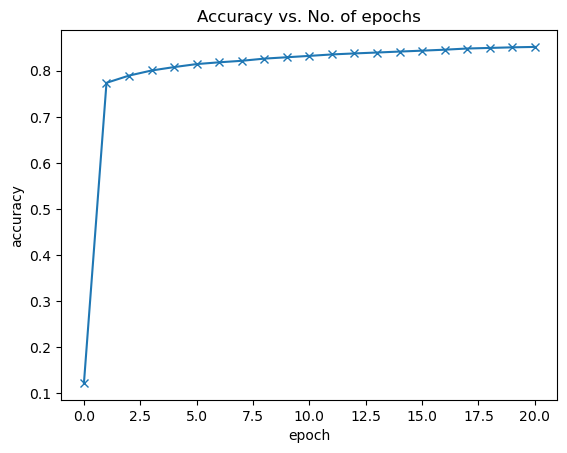

In [60]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result["val_acc"] for result in history]
plt.plot(accuracies, "-x")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs. No. of epochs")

In [61]:
# Define test dataset
test_dataset = MNIST(root="data/", train=False, transform=transforms.ToTensor())

In [62]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [63]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6117786169052124, 'val_acc': 0.864453136920929}

accuracy is 87%
